#Notebook Setup

In [402]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as k
import tensorflow_hub as hub
import tensorflow_text as text
import typing

import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

##Load cleaned dataset

In [494]:
df = pd.read_csv('/content/data_clean.csv')
df.head()

,label,text
0,0,jurong point crazy available bugis n great wor...
1,0,ok lar Joking wif u oni
2,1,free entry 2 wkly comp win FA Cup final tkts 2...
3,0,u dun early hor u c
4,0,nah I think usf live


#Tokenization & Padding

In [495]:
NUM_WORDS = 5000
BATCH_SIZE = 64

In [496]:
# Tokenization
df['text'] = df['text'].astype(str)

tokenizer = k.preprocessing.text.Tokenizer(num_words=NUM_WORDS, oov_token='oov')
tokenizer.fit_on_texts(df['text'])
df['token'] = tokenizer.texts_to_sequences(df['text'])

In [497]:
#Padding
padded = k.preprocessing.sequence.pad_sequences(
                    df['token'],
                    maxlen=None,
                    padding='post'
                    )

#Build the training set

In [498]:
x_train, x_val, y_train, y_val = train_test_split(
                    padded,
                    df['label'],
                    test_size=0.3,
                    stratify=df['label']
                    )

In [499]:
train, val = tf.data.Dataset.from_tensor_slices((x_train, y_train)), tf.data.Dataset.from_tensor_slices((x_val, y_val))
train_batch, val_batch = train.shuffle(len(train)).batch(BATCH_SIZE), val.shuffle(len(val)).batch(BATCH_SIZE)

# Word2Vec

In [500]:
import tensorflow.keras.layers as l

In [501]:
model = k.Sequential([
    l.Embedding(NUM_WORDS, 8, input_shape=[padded.shape[1],]),
    l.GlobalAveragePooling1D(),
    l.Dense(8, activation='swish'),
    l.Dropout(0.2),
    l.Dense(1, activation='sigmoid')
])


OPTIMIZER = k.optimizers.Adam(learning_rate=0.01)
model.compile(
    optimizer=OPTIMIZER,
    loss=k.losses.BinaryCrossentropy(),
    metrics=[k.metrics.BinaryAccuracy(), k.metrics.Recall(), k.metrics.Precision()],
    )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [502]:
model.summary()

Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_59 (Embedding)             │ (None, 73, 8)               │          40,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_39          │ (None, 8)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_116 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_117 (Dense)                    │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,081 (156.57 KB)

 Trainable params: 40,081 (156.57 KB)

 Non-trainable params: 0 (0.00 B)

#Training

In [503]:
def scheduler(epoch, lr):
    lr = lr * np.exp(-0.1)
    return lr
lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(train_batch, validation_data=val_batch, epochs=50, callbacks=[lr])

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - binary_accuracy: 0.8255 - loss: 0.4262 - precision_38: 0.1042 - recall_38: 0.0462 - val_binary_accuracy: 0.8660 - val_loss: 0.3608 - val_precision_38: 0.0000e+00 - val_recall_38: 0.0000e+00 - learning_rate: 0.0090
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.8743 - loss: 0.3550 - precision_38: 0.0000e+00 - recall_38: 0.0000e+00 - val_binary_accuracy: 0.8660 - val_loss: 0.3272 - val_precision_38: 0.0000e+00 - val_recall_38: 0.0000e+00 - learning_rate: 0.0082
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.8683 - loss: 0.3099 - precision_38: 0.4799 - recall_38: 0.0313 - val_binary_accuracy: 0.9139 - val_loss: 0.2010 - val_precision_38: 0.9348 - val_recall_38: 0.3839 - learning_rate: 0.0074
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9342 - loss: 0.1817 - precision_38: 0.9093 - recall_38: 0.5574 - val_binary_accuracy: 0.9635 - val_loss: 0.1216 - val_precision_38

In [504]:
model.evaluate(val_batch)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9892 - loss: 0.0534 - precision_38: 0.9973 - recall_38: 0.9231


[0.06661483645439148,
 0.9850478172302246,
 0.8973214030265808,
 0.9901477694511414]

#Evaluation

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1448
           1       0.99      0.90      0.94       224

    accuracy                           0.99      1672
   macro avg       0.99      0.95      0.97      1672
weighted avg       0.99      0.99      0.98      1672



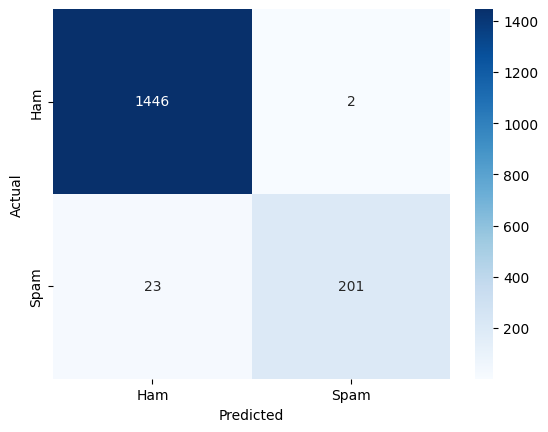

In [505]:
# Evaluation
def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred = np.where(y_pred < 0.5, 0, 1)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model(model, x_val, y_val)

## Let's redefine a preprocessing function so we can check if our model can detect a spam or not

In [575]:
import re
import spacy
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text.strip())
    return ' '.join([token.lemma_ for token in nlp(text) if token.lemma_ not in nlp.Defaults.stop_words])


##Let's test our model

In [576]:
# Single Message Prediction
def predict_spam(model, text):
    processed_text = tokenizer.texts_to_sequences([preprocess_text(text)])
    padded_text = k.preprocessing.sequence.pad_sequences(processed_text, maxlen=100, padding='post')
    pred = model.predict(padded_text)[0][0]
    return "Spam" if pred > 0.5 else "Ham"

##Examples

In [582]:
# SPAM Message
sample_text = "Congratulations! You’ve won a $500 Amazon gift card. Claim it here "
print("Prediction:", predict_spam(model, sample_text))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Prediction: Spam


In [583]:
# NOT a SPAM Message
sample_text = "The dog is in the garden. "
print("Prediction:", predict_spam(model, sample_text))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction: Ham
